# Bibliotecas

In [38]:
import os
import subprocess
import sys

def import_or_install(package, import_name=None):
    """
    Tenta importar um pacote. Se não for possível importá-lo, tenta instalar
    o pacote usando o pip e, em seguida, importá-lo novamente.

    Parâmetros:
        package (str): O nome do pacote a ser importado ou instalado.
        import_name (str): O nome do módulo a ser importado, se diferente do nome do pacote.

    Exemplo:
        >>> import_or_install('numpy')
        Tenta importar o pacote 'numpy'. Se não estiver disponível, tenta
        instalar usando o pip e, em seguida, importá-lo novamente.
    """
    import_name = import_name or package
    try:
        globals()[import_name] = __import__(import_name)
        print(f"Pacote {package} ({import_name}) encontrado.")
    except ImportError:
        print(f"Pacote {package} ({import_name}) não encontrado. Tentando instalar...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            globals()[import_name] = __import__(import_name)
            print(f"Pacote {package} ({import_name}) instalado e importado com sucesso.")
        except subprocess.CalledProcessError as e:
            print(f"Falha ao instalar o pacote {package}. Erro: {e}")
        except ImportError:
            print(f"Pacote {package} instalado, mas falha ao importar.")

# Atualizar pip antes de tentar instalar os pacotes
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
    print("pip atualizado com sucesso.")
except subprocess.CalledProcessError as e:
    print(f"Falha ao atualizar pip. Erro: {e}")

# Lista de pacotes a instalar com respectivos nomes de importação
pkgs = {
    'pandas': 'pandas',         
    'seaborn': 'seaborn',        
    'matplotlib': 'matplotlib',     
    'scipy': 'scipy',          
    'numpy': 'numpy',          
    'scikit-learn': 'sklearn',   # scikit-learn é importado como sklearn
    'pydeseq2': 'pydeseq2',       
    'gseapy': 'gseapy',         
    'sanbomics': 'sanbomics',      
    'fastcluster': 'fastcluster'     
}

# Tentar instalar e importar cada pacote
for pkg, import_name in pkgs.items():
    import_or_install(pkg, import_name)

# Verificar se todos os pacotes foram importados corretamente
for pkg, import_name in pkgs.items():
    if import_name not in globals():
        print(f"Pacote {pkg} ({import_name}) não foi importado corretamente.")
    else:
        print(f"Pacote {pkg} ({import_name}) importado com sucesso.")


pip atualizado com sucesso.
Pacote pandas (pandas) encontrado.
Pacote seaborn (seaborn) encontrado.
Pacote matplotlib (matplotlib) encontrado.
Pacote scipy (scipy) encontrado.
Pacote numpy (numpy) encontrado.
Pacote scikit-learn (sklearn) encontrado.
Pacote pydeseq2 (pydeseq2) encontrado.
Pacote gseapy (gseapy) encontrado.
Pacote sanbomics (sanbomics) encontrado.
Pacote fastcluster (fastcluster) encontrado.
Pacote pandas (pandas) importado com sucesso.
Pacote seaborn (seaborn) importado com sucesso.
Pacote matplotlib (matplotlib) importado com sucesso.
Pacote scipy (scipy) importado com sucesso.
Pacote numpy (numpy) importado com sucesso.
Pacote scikit-learn (sklearn) importado com sucesso.
Pacote pydeseq2 (pydeseq2) importado com sucesso.
Pacote gseapy (gseapy) importado com sucesso.
Pacote sanbomics (sanbomics) importado com sucesso.
Pacote fastcluster (fastcluster) importado com sucesso.


# Upload dos Dados

Os dados para esta parte de python foram obtidos por conversão das variáveis em R. Usamos os packages TCGA BioLinks para transferir os dados necessários e depois estes foram exportados.

A lógica em R:

```r
write_csv(seqdata, 'seqdata.csv') # Para excluir os rownames e manter os nomes do gene
write_csv(meta, 'meta.csv', rownames = FALSE) # Para manter o barcode
```

In [39]:
print('A criar pasta para output')

if not os.path.exists('./output'):
    os.mkdir('./output')    

A criar pasta para output


# Pré-processamento de dados

Abaixo é realizado o pré-processamento dos dados importados. É utilizada uma pipeline comum com a biblioteca `pandas`, sendo realizadas várias operações de modificação de índices, nomes de colunas e filtragem de dados. O resultado final é um *dataframe* com 248 colunas, correspondente às amostras com subtipo de adenocarcinoma do pulmão e 60660 linhas correspondentes a todos os genes analisados. Os passos seguintes consistirão na filtragem dos dados com base em CPM (*counts per million*).

In [40]:
floc = './dataset/seqdata.csv'
print(f'A importar o dataframe na localização {floc}\n')
seqdata = pandas.read_csv('./dataset/seqdata.csv')
print('A renomear colunas e a definir genes como índice.\n')
seqdata = seqdata.rename(columns={'Unnamed: 0':'Genes'})
seqdata = seqdata.set_index('Genes')
print('Concluído!',
      'Dataframe seqdata com:',
      f'    - {seqdata.shape[1]} colunas',
      f'    - {len(seqdata)} linhas',
      sep= '\n'
      )
print('A mostrar head do dataframe\n',seqdata.head())

A importar o dataframe na localização ./dataset/seqdata.csv

A renomear colunas e a definir genes como índice.

Concluído!
Dataframe seqdata com:
    - 600 colunas
    - 60660 linhas
A mostrar head do dataframe
           TCGA-38-7271-01A-11R-2039-07  TCGA-55-7914-01A-11R-2170-07  \
Genes                                                                  
TSPAN6                            1536                          2936   
TNMD                                 0                             0   
DPM1                               765                          1447   
SCYL3                              510                           827   
C1orf112                           172                           241   

          TCGA-95-7043-01A-11R-1949-07  TCGA-73-4658-01A-01R-1755-07  \
Genes                                                                  
TSPAN6                            1475                          3659   
TNMD                                 0                           18

# Metadados

## Carregamento dos metadados 1.0

In [41]:
# Carregamento de metadados
floc = './dataset/meta.csv'
print(f'A importar o dataframe na localização {floc}\n')
meta = pandas.read_csv('./dataset/meta.csv')
print('A renomear colunas e a definir barcode como índice.\n')
meta = meta.set_index('barcode')
print('Concluído!',
      'Dataframe seqdata com:',
      f'    - {meta.shape[1]} colunas',
      f'    - {len(meta)} linhas',
      sep= '\n'
      )
print('A mostrar head do dataframe\n',meta.head())

A importar o dataframe na localização ./dataset/meta.csv

A renomear colunas e a definir barcode como índice.

Concluído!
Dataframe seqdata com:
    - 2 colunas
    - 600 linhas
A mostrar head do dataframe
                               gender           expr
barcode                                            
TCGA-38-7271-01A-11R-2039-07  female            NaN
TCGA-55-7914-01A-11R-2170-07  female            TRU
TCGA-95-7043-01A-11R-1949-07  female  prox.-prolif.
TCGA-73-4658-01A-01R-1755-07  female   prox.-inflam
TCGA-86-8076-01A-31R-2241-07    male            NaN


### Verificação de valores omissos

In [42]:
# Verifica a existência de dados omissos
print('A verificar a existência de dados omissos:', meta.isna().any(), sep='\n')

A verificar a existência de dados omissos:
gender    False
expr       True
dtype: bool


In [43]:
# Remover NAs do expr. subtype
print('A remover dados omissos do dataframe de metadados.')
meta_clean = meta.dropna(how='any')

if len(meta_clean) == 248:
    print(f'data set de subtipo de expressão contém 248 valores como esperado, com tamanho {len(meta_clean)}')
    
print('Concluído!',
      'A mostrar head do dataframe tratado:',
      meta_clean.head(),
      sep='\n')

A remover dados omissos do dataframe de metadados.
data set de subtipo de expressão contém 248 valores como esperado, com tamanho 248
Concluído!
A mostrar head do dataframe tratado:
                              gender           expr
barcode                                            
TCGA-55-7914-01A-11R-2170-07  female            TRU
TCGA-95-7043-01A-11R-1949-07  female  prox.-prolif.
TCGA-73-4658-01A-01R-1755-07  female   prox.-inflam
TCGA-55-7726-01A-11R-2170-07  female   prox.-inflam
TCGA-44-6147-01A-11R-A278-07  female            TRU


### Filtragem das colunas do dataframe seqdata de acordo com os metadados existentes

In [44]:
# Filtrar seqdata com base no filtro
print('A reorganizar e filtrar dataframe seqdata com base nos índices dos metadados.')
seqdata_clean = seqdata[meta_clean.index] # Não é preciso validar pois as colunas já estão pelo nome
print('Concluído!')

A reorganizar e filtrar dataframe seqdata com base nos índices dos metadados.
Concluído!


## Carregamento dos metadados 2.0

Foi feita um segundo objeto com metadados relacionados com os hábitos de fumo e com o estado vital.

### Hábitos de fumo

In [45]:
# Carregamento de hábitos de fumo
floc = './dataset/fumo.csv'
print(f'A importar o dataframe na localização {floc}\n')
smoke_status = pandas.read_csv('./dataset/fumo.csv')
print('A renomear colunas.\n')
smoke_status = smoke_status.rename(columns={
    'data.paper_Smoking.Status' : 'Smoke Habits',
    'data.years_smoked' : 'Years Smoked'})
print('A corrigir índice de acordo com o índice do dataframe de metadados.')
smoke_status.drop(columns=['Unnamed: 0', 'Years Smoked'], inplace=True)
smoke_status['barcode'] = meta.index

# Filtramos por Smoke Habits
print('A limpar dados:')
print('Removendo dados omissos.')
smoke_status.isna().any()
smoke_status_clean = smoke_status[(smoke_status['Smoke Habits'].notna()) & (smoke_status['Smoke Habits'] != '[Not Available]')]
print('A gerar dataset limpo')
smoke_status_clean = smoke_status_clean[['barcode', 'Smoke Habits']]
print('Concluído!',
      'Dataframe seqdata com:',
      f'    - {smoke_status_clean.shape[1]} colunas',
      f'    - {len(smoke_status_clean)} linhas',
      sep= '\n'
      )
print('A mostrar head do dataframe\n',smoke_status_clean.head())



A importar o dataframe na localização ./dataset/fumo.csv

A renomear colunas.

A corrigir índice de acordo com o índice do dataframe de metadados.
A limpar dados:
Removendo dados omissos.
A gerar dataset limpo
Concluído!
Dataframe seqdata com:
    - 2 colunas
    - 237 linhas
A mostrar head do dataframe
                         barcode                                 Smoke Habits
1  TCGA-55-7914-01A-11R-2170-07                               Current smoker
2  TCGA-95-7043-01A-11R-1949-07  Current reformed smoker for < or = 15 years
3  TCGA-73-4658-01A-01R-1755-07       Current reformed smoker for > 15 years
5  TCGA-55-7726-01A-11R-2170-07       Current reformed smoker for > 15 years
6  TCGA-44-6147-01A-11R-A278-07       Current reformed smoker for > 15 years


### Estado vital

In [46]:
vital = pandas.read_csv('./dataset/vital.csv')

vital.rename(columns={'data.barcode' : 'barcode', 'data.vital_status' : 'Vital Status'}, inplace=True)

vital_vs_smoke = pandas.merge(
    smoke_status_clean,
    vital,
    on = 'barcode',
    how = 'inner'
)

vital_vs_smoke = vital_vs_smoke[['barcode', 'Smoke Habits', 'Vital Status']]
vital_vs_smoke['Smoke Habits'] = vital_vs_smoke['Smoke Habits'].replace(
    {'Current reformed smoker for > 15 years' : 'EX > 15 y',
    'Current reformed smoker for < or = 15 years' : 'EX <= 15 y',
    'Current smoker': 'Smokes',
    'Lifelong Non-smoker': 'Never smoked'
})
vital_vs_smoke

,barcode,Smoke Habits,Vital Status
0,TCGA-55-7914-01A-11R-2170-07,Smokes,Dead
1,TCGA-95-7043-01A-11R-1949-07,EX <= 15 y,Dead
2,TCGA-73-4658-01A-01R-1755-07,EX > 15 y,Dead
3,TCGA-55-7726-01A-11R-2170-07,EX > 15 y,Alive
4,TCGA-44-6147-01A-11R-A278-07,EX > 15 y,Alive
...,...,...,...
232,TCGA-78-7153-01A-11R-2039-07,EX <= 15 y,Alive
233,TCGA-38-4628-01A-01R-1206-07,Never smoked,Dead
234,TCGA-86-7713-01A-11R-2066-07,Never smoked,Alive
235,TCGA-44-2662-01B-02R-A277-07,EX > 15 y,Alive


## Carregamento dos metadados 3.0

In [47]:
stage = pandas.read_csv('./dataset/stage.csv')
stage.drop(columns=['Unnamed: 0'], inplace=True)

stage = stage.rename(columns={'data$paper_Tumor.stage' : 'Tumor Stage'})

stage['barcode'] = meta.index

print(f'encontrados {stage.iloc[:, 0].isna().sum()} valores omissos',
           'foi criada uma versão filtrada')

stage_clean = stage.dropna(how='any')
stage_clean[stage_clean['barcode'].isin(meta.index)]
stage_clean

encontrados 352 valores omissos foi criada uma versão filtrada


,Tumor Stage,barcode
1,Stage IIA,TCGA-55-7914-01A-11R-2170-07
2,Stage IA,TCGA-95-7043-01A-11R-1949-07
3,Stage IB,TCGA-73-4658-01A-01R-1755-07
5,Stage IA,TCGA-55-7726-01A-11R-2170-07
6,Stage IA,TCGA-44-6147-01A-11R-A278-07
...,...,...
588,Stage IIA,TCGA-50-5055-01A-01R-1628-07
589,Stage IIB,TCGA-38-4628-01A-01R-1206-07
591,Stage IB,TCGA-86-7713-01A-11R-2066-07
593,Stage IB,TCGA-44-2662-01B-02R-A277-07


## Conjuntos

No final, foram criados três conjuntos de metadados:

* Conjunto 1 (**meta**): género e tipo de expressão

* Conjunto 2 (**vital_vs_smoke**): hábitos de fumo e estado vital

* Conjunto 3 (**stage_clean**): estágio de tumor

# Análise inicial dos dados

À semelhança do trabalho realizado em R, são realizadas algumas análise estatísticas básicas com o intuito do correlacionar dados, nomeadamente:
* Distribuição de estado vital;
* Distribuição de hábitos de fumo;
* Distribuição de sexo biológico;
* Correlação Hábitos de fumo / Estado vital;

Os resultados obtidos e os gráficos demonstrados são iguais aos demonstrados ao longo do relatório desenvolvido utilizando R, sendo a principal diferença o tipo de bibliotecas utilizadas.

## Estado vital

A preparar tabela de contingência para estado vital.
A preparar o gráfico.


Concluído, a exibir gráfico abaixo.
Plot gravado em ./output



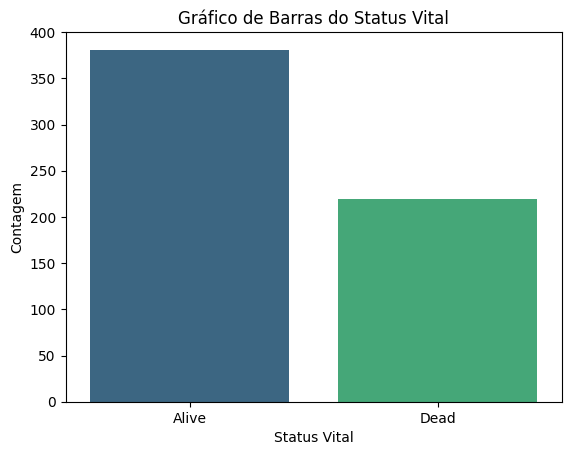

In [48]:
print('A preparar tabela de contingência para estado vital.')
vital_status = vital['Vital Status'].value_counts()

# Plotting the bar plot
print('A preparar o gráfico.')
seaborn.barplot(x=vital_status.index, y=vital_status.values, palette="viridis")

matplotlib.pyplot.title("Gráfico de Barras do Status Vital")
matplotlib.pyplot.xlabel("Status Vital")
matplotlib.pyplot.ylabel("Contagem")


matplotlib.pyplot.savefig('./output/vital_status.pdf')
# Showing the plot
print('Concluído, a exibir gráfico abaixo.', 'Plot gravado em ./output\n',sep='\n')
matplotlib.pyplot.show()

## Hábitos de fumo

A preparar tabela de contingência para hábitos de fumo.
A preparar o gráfico.
Concluído, a exibir gráfico abaixo.
Plot gravado em ./output/



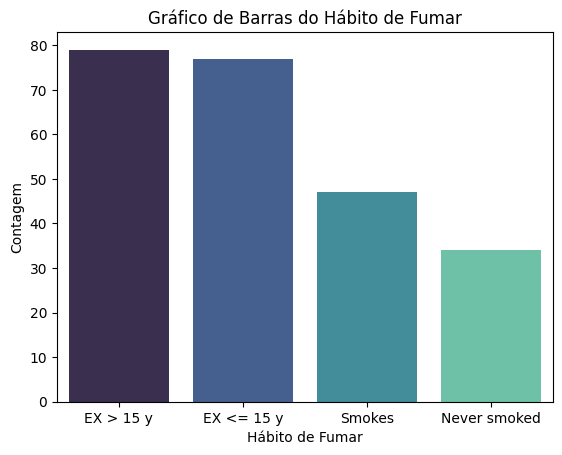

In [49]:
# Adjusting smoke habit data
print('A preparar tabela de contingência para hábitos de fumo.')
smoke_habit = smoke_status_clean['Smoke Habits'].value_counts()
smoke_habit = smoke_habit.rename({
    'Current reformed smoker for > 15 years': 'EX > 15 y',
    'Current reformed smoker for < or = 15 years': 'EX <= 15 y',
    'Current smoker': 'Smokes',
    'Lifelong Non-smoker': 'Never smoked',
})

print('A preparar o gráfico.')
# Plotting smoke habit data
seaborn.barplot(x=smoke_habit.index, y=smoke_habit.values, palette="mako")

matplotlib.pyplot.title("Gráfico de Barras do Hábito de Fumar")
matplotlib.pyplot.xlabel("Hábito de Fumar")
matplotlib.pyplot.ylabel("Contagem")

matplotlib.pyplot.savefig('./output/smoke_habit.pdf')
# Showing the plot
print('Concluído, a exibir gráfico abaixo.', 'Plot gravado em ./output/\n',sep='\n')
matplotlib.pyplot.show()

## Hábitos de fumo vs Estado vital

Correlacionar hábitos de fumo com estado vital através de teste qui-quidrado.
A preparar tabela de contingência para alfa = 0.05
A realizar teste qui-quadrado.
Concluído, resultados abaixo:
Estatística de teste:2.954414510442226
Graus de liberdade:3
Valor de prova:0.3987070944866199
Para alfa = 0.05:
Não é plausível considerar correlação
A criar um gráfico para os resultados.
Concluído, a exibir gráfico abaixo.
Plot gravado em ./output/



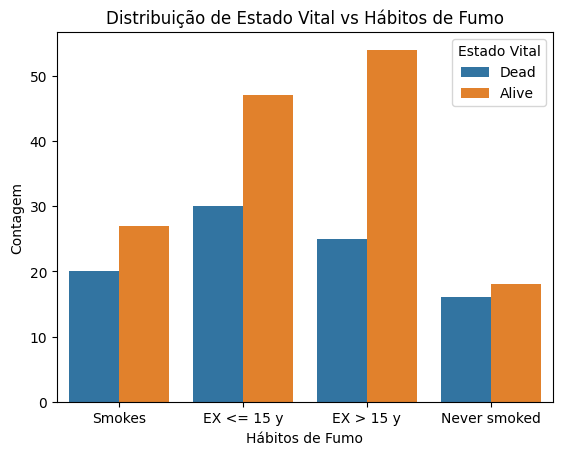

In [50]:
print('Correlacionar hábitos de fumo com estado vital através de teste qui-quidrado.',
      'A preparar tabela de contingência para alfa = 0.05',
      sep='\n')
contingency_table = pandas.crosstab(vital_vs_smoke['Vital Status'], vital_vs_smoke['Smoke Habits'])
alpha = 0.05
print('A realizar teste qui-quadrado.')
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
print('Concluído, resultados abaixo:',
      f'Estatística de teste:{chi2}',
      f'Graus de liberdade:{dof}',
      f'Valor de prova:{p}',
      f'Para alfa = {0.05}:',
      sep = '\n')

# para 95% IC
if p < 0.05:
    print('É plausível considerar correlação')
    
else:
    print('Não é plausível considerar correlação')

print('A criar um gráfico para os resultados.')
seaborn.countplot(x='Smoke Habits', hue = 'Vital Status', data = vital_vs_smoke)
matplotlib.pyplot.title('Distribuição de Estado Vital vs Hábitos de Fumo')
matplotlib.pyplot.xlabel('Hábitos de Fumo')
matplotlib.pyplot.ylabel('Contagem')
matplotlib.pyplot.legend(title = 'Estado Vital')

matplotlib.pyplot.savefig('./output/vital_vs_smoke.pdf')
print('Concluído, a exibir gráfico abaixo.', 'Plot gravado em ./output/\n',sep='\n')
matplotlib.pyplot.show()


    

# Análise de Expressão Diferencial utilizando PyDESEQ2

Para a análise de expressão genética diferencial em Python utilizamos a biblioteca `PyDESEQ2`, uma adaptação da biblioteca R DESEQ2. 

In [51]:
# Pipeline
# https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_pandas_io_example.html
# https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_step_by_step.html
# Credits to mousepixels: https://github.com/mousepixels/sanbomics_scripts/blob/main/PyDeseq2_DE_tutorial.ipynb
# And PyDeSEQ2 documentation

import pickle
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats


Os dados para análise diferencial de expressão foram transpostos para uma tabela de contagens, verificando a correspondência dos dados com os metadados, e filtrando genes com contagens totais superiores a 10.

In [52]:
print('A preparar dados para DESEQ:,'
      ' - Transport tabela de counts para cada gene',
      sep='\n')
counts = seqdata_clean
counts_df = counts.T
print('A criar tabela de metadados e verificar se todos os dados correspondem corretamente.')
metadata = meta_clean[['expr']]
# Verificar se dados correspondem
if (counts_df.index == meta_clean.index).all():
    print('Dados correspondem corretamente, a filtrar dataset retendo genes com counts > 10')
    genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
    print('A converter em dataframe')
    counts_df = counts_df[genes_to_keep]

A preparar dados para DESEQ:, - Transport tabela de counts para cada gene
A criar tabela de metadados e verificar se todos os dados correspondem corretamente.
Dados correspondem corretamente, a filtrar dataset retendo genes com counts > 10
A converter em dataframe


In [53]:
import pydeseq2

inference = pydeseq2.default_inference.DefaultInference(n_cpus=8)
print('A gerar objeto DeseqDataSet')
dds = pydeseq2.dds.DeseqDataSet(
    counts = counts_df,
    metadata = metadata,
    design_factors='expr',
    refit_cooks=True,
    inference = inference
)

if type(dds) == pydeseq2.dds.DeseqDataSet:
    print('Dataset criado, a correr operações DESEQ:')
    dds.deseq2()


A gerar objeto DeseqDataSet
Dataset criado, a correr operações DESEQ:


Fitting size factors...
... done in 2.09 seconds.

Fitting dispersions...
... done in 24.30 seconds.

Fitting dispersion trend curve...
... done in 3.16 seconds.

Fitting MAP dispersions...
... done in 28.63 seconds.

Fitting LFCs...
... done in 16.62 seconds.

Replacing 8916 outlier genes.

Fitting dispersions...
... done in 4.65 seconds.

Fitting MAP dispersions...
... done in 4.27 seconds.

Fitting LFCs...
... done in 3.74 seconds.



In [54]:
# Guardar para acelerar o processo mais á frente com o load (estilo RDA/RDS)
# open("dds.pkl", "wb") as f:
#    pickle.dump(dds, f)
    
# 
#with open('dds.pkl', 'rb') as f:
#    pickle.load(f)

## Testes de Wald

Na célula abaixo é feito o tratamento estatístico dos resultados, sendo realizados testes de Wald para comparar a expressão genética de diferentes genes analisados com o objetivo de verificar e comparar se existem genes diferencialmente expressos entre as diferentes amostras. Neste caso concreto são comparadas as condições Proximal Proliferative (Prof. Prolif) vs Terminal Respiratory Unit (TRU) e Proximal Inflamatory (Prox. Inflam) vs Terminal Respiratory Unit (TRU). 

O resultado da análise consiste numa tabela com:
 * os níveis médios da expressão genética;
  * a taxa de sobre/sobexpressão sob a forma $log_{2}(\frac{Expressão na condição A}{Expressão na condição B}$;
  * resultados do teste estatístico, nomeadamente os valores de prova;


In [55]:
# Crie um objeto DeseqStats usando o conjunto de dados DESeq fornecido (dds) e os parâmetros especificados
# alpha: nível de significância para o teste (padrão 0.05)
# cooks_filter: se aplicar ou não a filtragem de distância de Cook para remover possíveis outliers
# independent_filter: se aplicar ou não a filtragem independente para aumentar o poder, removendo genes com contagem baixa
# inference: especifica o tipo de inferência estatística a ser usada (por exemplo, 'paramétrica', 'não paramétrica')
print('A executar tratamento estatístico dos dados.')
stat_res = pydeseq2.ds.DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True, inference=inference)

# Execute o teste de Wald para análise de expressão diferencial no conjunto de dados DESeq
# O teste de Wald é um teste paramétrico usado para determinar se há uma diferença significativa na expressão
# Ele calcula valores de p e log fold changes para cada gene no conjunto de dados
print('A executar testes de Wald.')
stat_res.run_wald_test()

# Recupere os resultados do teste de Wald como um DataFrame do pandas
# Este DataFrame contém os resultados da análise de expressão diferencial, incluindo:
# - log fold changes
# - valores de p
# - valores de p ajustados (corrigidos para testes múltiplos)
# - estatísticas adicionais e metadados para cada gene
print('Concluído, a exibir resultados:')
stat_res.summary()



A executar tratamento estatístico dos dados.
A executar testes de Wald.


Running Wald tests...
... done in 8.71 seconds.



Concluído, a exibir resultados:
Log2 fold change & Wald test p-value: expr prox.-inflam vs TRU
                    baseMean  log2FoldChange     lfcSE      stat  \
Genes                                                              
TSPAN6           3372.659142        0.055701  0.104359  0.533749   
TNMD                7.405713        1.198674  0.465215  2.576601   
DPM1             1505.153644        0.424534  0.086944  4.882840   
SCYL3             778.112463       -0.171164  0.076256 -2.244583   
C1orf112          373.207836        0.725551  0.097846  7.415237   
...                      ...             ...       ...       ...   
ENSG00000288667     1.368924        0.404061  0.983904  0.410671   
ENSG00000288669     0.200104        0.859831  0.967010  0.889165   
ENSG00000288670   251.434561       -0.166020  0.100246 -1.656119   
ENSG00000288674     5.382479       -0.612823  0.136808 -4.479424   
ENSG00000288675    13.979935       -0.184320  0.129677 -1.421377   

                    

Em seguida filtramos os dados, definindo como filtro:
 * valor de prova seja tal que seja plausível considerar que são diferencialmente expressos (para um intervalo de confiança de 95%);
  * valor de $| log_{2}FC |$ superior a  2, indicativo de um nível de sobre/sobexpressão
  * CPM superior a 20

In [56]:
# Extracting the results DataFrame from the statistical results object
print('A isolar dataframe de resultados')
rdf = stat_res.results_df

# Print the initial number of genes present in the results DataFrame
# This provides a count of the total number of rows (genes) before filtering
print('Genes inicialmente presentes -->', len(rdf))  # Expected to be > 52310

# Apply filtering criteria to select significant genes:
# - Adjusted p-value (padj) < 0.05
# - Absolute value of log2 fold change (|log2FoldChange|) > 2
# - Base mean expression (baseMean) > 20
significant = rdf[(rdf.padj < 0.05) & (abs(rdf.log2FoldChange) > 2) & (rdf.baseMean > 20)]

# Print the number of genes that meet the differential expression criteria
# This gives an idea of the subset size that meets the specified thresholds
print(f'Genes mais diferencialmente expressos (log2FoldChange > 2, CPM > 20, padj < 0.05 -->', len(significant))  # Expected to be > 695

# Sort the significant genes by the adjusted p-value (padj) in ascending order
# This ensures that the most significant genes are at the top of the DataFrame
significant = significant.sort_values(by='padj')

# Display the top 100 genes based on the sorted DataFrame
# This returns the first 100 rows (genes) after sorting
significant_top_100 = significant.head(100)

# Print the indexes of the top 100 differentially expressed genes
# This provides a list of the most significant genes based on the filtering and sorting criteria
#print('Lista dos 100 genes mais diferencialmente expressos:', *significant_top_100.index, sep='\n')

A isolar dataframe de resultados
Genes inicialmente presentes --> 52310
Genes mais diferencialmente expressos (log2FoldChange > 2, CPM > 20, padj < 0.05 --> 279


A criar MA Plot .
MA Plot gravado em ./output/


<Figure size 640x480 with 0 Axes>

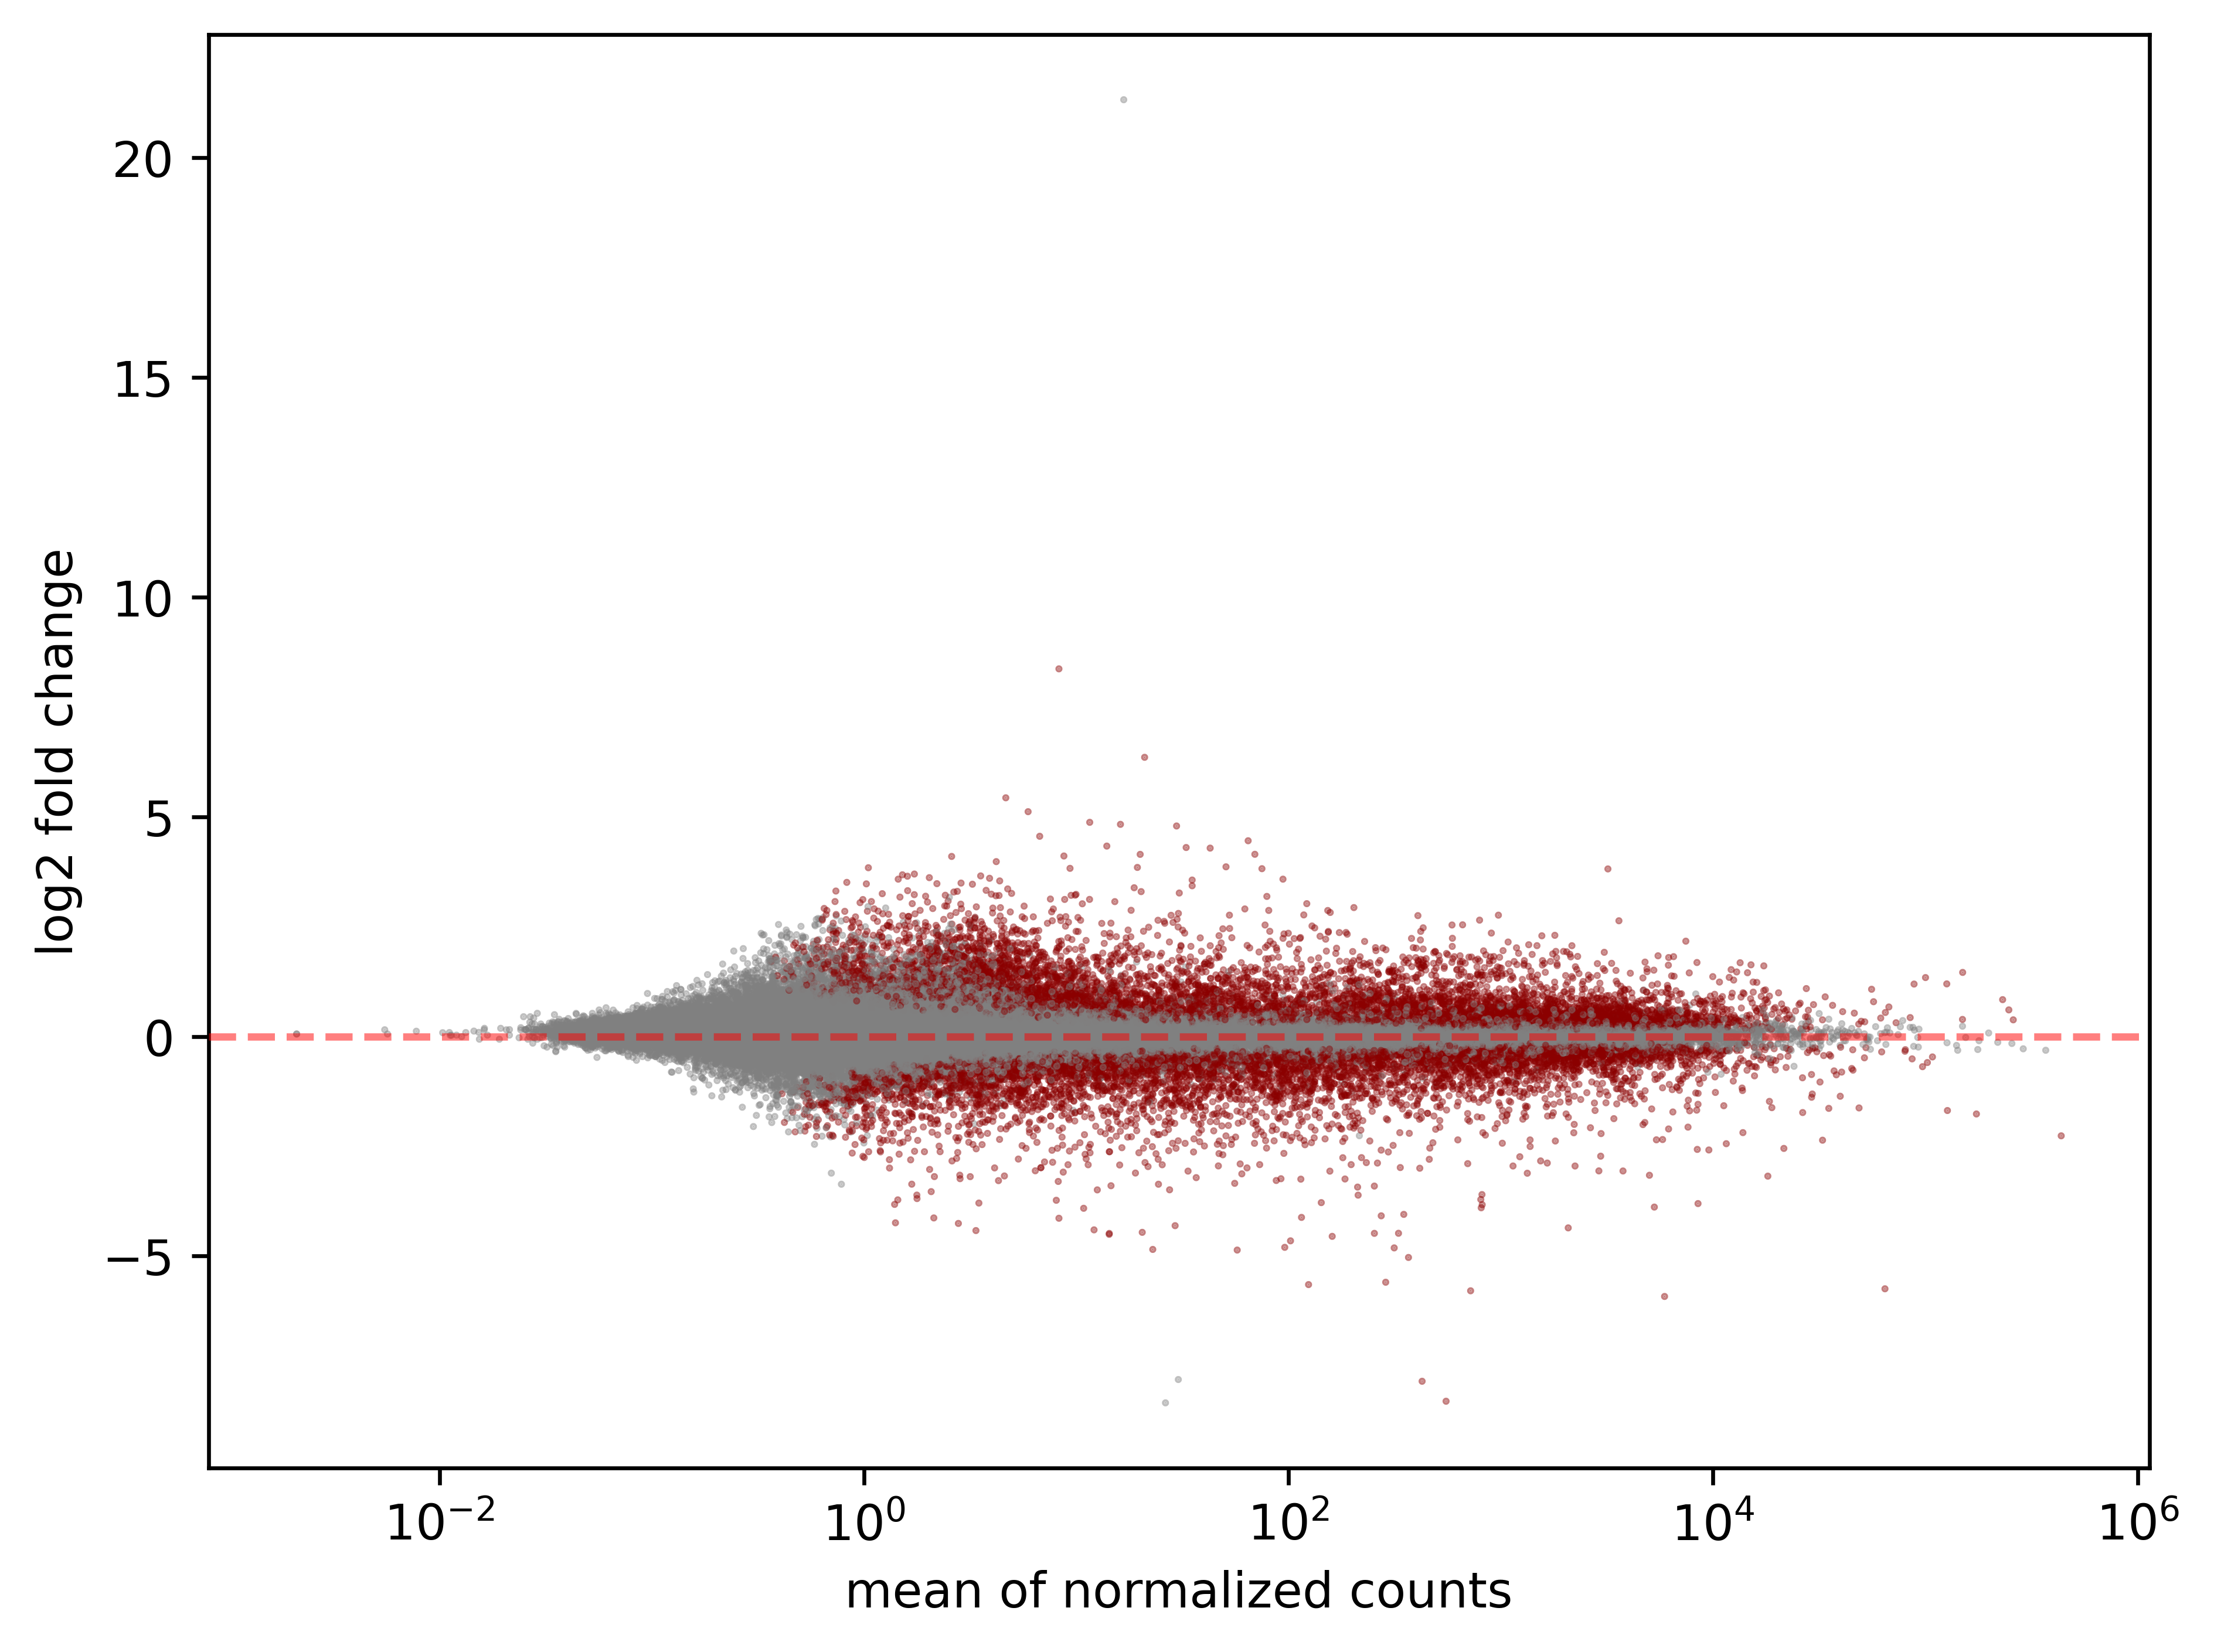

In [57]:
#MA Plot
print('A criar MA Plot .')
matplotlib.pyplot.figure()
stat_res.plot_MA()
print('MA Plot gravado em ./output/')
matplotlib.pyplot.savefig('./output/MA_Plot.pdf')

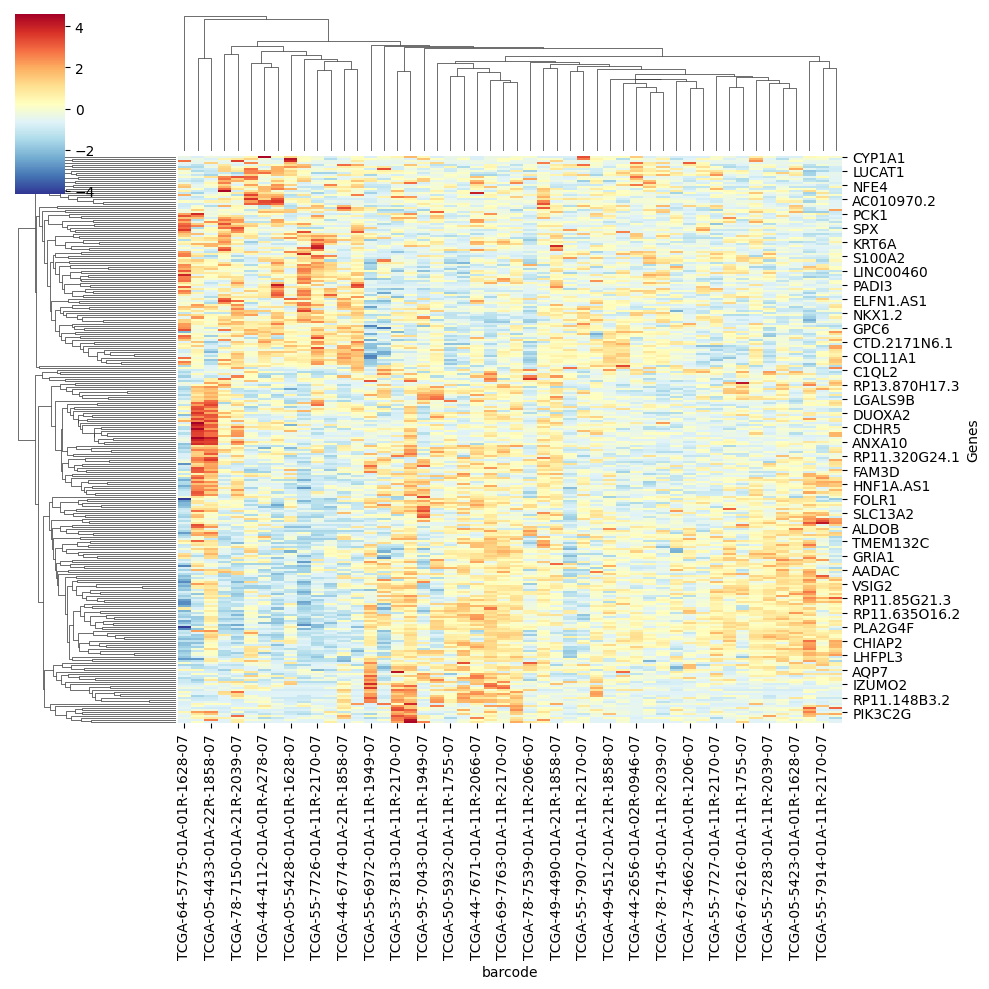

In [58]:
# Assuming 'dds' is a DESeqDataSet object with layers and observations (obs)

# Compute log-transformed counts and store them in a new layer 'logcounts'
# np.log1p(x) computes log(1 + x) which helps in managing zeros in the data
dds.layers['logcounts'] = numpy.log1p(dds.layers['normed_counts'])

# Display the 'logcounts' layer to verify the transformation
dds.layers['logcounts']

# Subset the DESeqDataSet to include only the first 50 rows and the significant indices
dds_sigs = dds[:50, significant.index]

# Create a DataFrame for graphing with the log-transformed counts
# The DataFrame's index is the variable names (var_names)
# The DataFrame's columns are the observation names (obs_names)
grapher = pandas.DataFrame(
    dds_sigs.layers['logcounts'].T,
    index=dds_sigs.var_names,
    columns=dds_sigs.obs_names
)

# Plot a clustered heatmap of the data using seaborn's clustermap function
# z_score=0 standardizes the rows (genes) by subtracting the mean and dividing by the standard deviation
# cmap='RdYlBu_r' sets the color map to a diverging palette from red to yellow to blue, reversed
clustermap = seaborn.clustermap(grapher, z_score=0, cmap='RdYlBu_r')

clustermap.savefig('./output/heatmap.pdf')

A análise de um heatmap, ou mapa de calor, é uma etapa crucial na interpretação de dados de expressão gênica ou qualquer outro tipo de matriz de dados multidimensionais. O heatmap visualiza a intensidade dos valores em uma matriz através de cores, permitindo a identificação de padrões e tendências subjacentes nos dados. Ao analisar um heatmap, é importante observar clusters de elementos que compartilham padrões semelhantes de expressão, representados por blocos de cores semelhantes. Esses clusters podem indicar grupos de genes ou amostras que têm perfis de expressão semelhantes, sugerindo associações biológicas ou correlações funcionais. Além disso, a análise dos gradientes de cor ao longo de linhas e colunas pode revelar padrões de expressão específicos em diferentes condições experimentais ou em diferentes grupos de amostras. A interpretação de um heatmap também pode ser guiada por metadados associados às linhas e colunas da matriz, como anotações biológicas, condições experimentais ou fenótipos das amostras. Em resumo, a análise de um heatmap é uma etapa fundamental na exploração e interpretação de dados de expressão gênica e outras matrizes de dados, fornecendo insights valiosos sobre padrões de expressão e relações entre elementos na matriz.

## Análise de enriquecimento

Abaixo foi desenvolvida a análise de enriquecimento. 

A análise de enriquecimento de conjuntos de genes (GSEA, do inglês Gene Set Enrichment Analysis) é uma abordagem estatística poderosa e amplamente utilizada em genômica funcional para identificar padrões biológicos e processos celulares associados a conjuntos de genes específicos. Ao contrário de métodos convencionais que se concentram na análise de genes individualmente, a GSEA avalia se um conjunto predefinido de genes, agrupados com base em funções biológicas, vias metabólicas ou outras características, está significativamente enriquecido em uma amostra experimental em comparação com amostras de controle. Essa análise leva em consideração a co-regulação de genes dentro de um conjunto, permitindo uma compreensão mais holística e contextualizada das alterações moleculares associadas a fenótipos biológicos específicos. A GSEA é uma ferramenta fundamental para a interpretação de dados de expressão gênica de alto rendimento, como microarranjos de DNA e sequenciamento de RNA, fornecendo insights valiosos sobre processos biológicos subjacentes em uma escala sistêmica.

In [59]:
print('A mostrar a lista de bibliotecas de genes.')
gseapy.get_library_name()

A mostrar a lista de bibliotecas de genes.


['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [60]:
lib = 'MSigDB_Oncogenic_Signatures'

print('A executar análise de enriquecimento e atribuição de rankings com base nos valores.',
      f'Irá ser utilizada a biblioteca {lib} por conter os oncogenes mais comuns.', sep='\n')
ranking = rdf[['stat']].dropna().sort_values('stat', ascending=False)

pre_res = gp.prerank(rnk = ranking,
                     gene_sets= ['MSigDB_Oncogenic_Signatures'],
                     seed = 6, permutation_num=100
                     )
print(
    'Concluído!',
    'A mostrar resultados de enriquecimento: ',
    '   - 3 genes com maior enrichment score (positivamente associados\n',
    pre_res.res2d[['Term','NES']].head(3),
    '   \n- 3 genes com menor enrichment score (negativamente associados)\n',
    pre_res.res2d[['Term','NES']].tail(3),
    sep='\n'
)



A executar análise de enriquecimento e atribuição de rankings com base nos valores.
Irá ser utilizada a biblioteca MSigDB_Oncogenic_Signatures por conter os oncogenes mais comuns.


NameError: name 'gp' is not defined

Abaixo são construídos os diferentes GSEA plots para os top 3 / bottom 3 genes.

Os GSEA plots, ou gráficos de análise de enriquecimento de conjuntos de genes, são uma representação visual essencial na interpretação dos resultados da análise de enriquecimento GSEA. Esses gráficos exibem a distribuição acumulada de genes dentro de conjuntos funcionais pré-definidos ao longo de uma lista ordenada de genes, geralmente classificados por sua relevância em uma comparação de condições experimentais. A interpretação dos GSEA plots envolve a identificação de picos ou vales significativos na curva de enriquecimento, indicando conjuntos de genes que estão sobre-representados (enriquecidos) ou sub-representados (depletados) em uma condição experimental específica. Além disso, a análise de fenômenos como a localização e a amplitude dos picos, bem como a consistência dos resultados em diferentes conjuntos de genes e replicatas experimentais, desempenha um papel crucial na validação e na interpretação biológica dos resultados da GSEA. Em resumo, os GSEA plots oferecem uma representação visual intuitiva e informativa dos padrões de enriquecimento de conjuntos de genes, facilitando a compreensão dos processos biológicos subjacentes a diferentes estados ou fenótipos celulares.

In [ ]:
terms = pre_res.res2d.Term
top_bottom_3 = [0,1,2,len(terms) - 1, len(terms) - 2, len(terms) - 3]
print(f'A mostrar plot para os termos:',*top_bottom_3, '(Top 3 / Bottom 3)')
i = 0
import os
for term in top_bottom_3:
    if not os.path.exists('./output/gsea_plots'):
        os.makedirs('./output/gsea_plots')
    gseapy.gseaplot(rank_metric=pre_res.ranking, term=terms[term], **pre_res.results[terms[term]])
    print(f'A gravar plot para {terms[term]}')
    gseapy.gseaplot(rank_metric=pre_res.ranking, term=terms[term], ofname=f'./output/gsea_plots/{terms[term]}.pdf', **pre_res.results[terms[term]])
    i += 1

NameError: name 'pre_res' is not defined

Os GSEA plots, ou gráficos de análise de enriquecimento de conjuntos de genes, são ferramentas visuais cruciais na interpretação dos resultados de análise de enriquecimento GSEA. Esses gráficos exibem a distribuição acumulada de genes de conjuntos funcionais pré-definidos ao longo de uma lista ordenada de genes, geralmente classificados por sua relevância em uma comparação de condições experimentais. A interpretação dos GSEA plots envolve a identificação de picos ou vales significativos na curva de enriquecimento, indicando conjuntos de genes que estão sobre-representados (enriquecidos) ou sub-representados (depletados) em uma condição experimental específica. Além disso, a análise de fenômenos como a localização e a amplitude dos picos, bem como a consistência dos resultados em diferentes conjuntos de genes e replicatas experimentais, desempenha um papel crucial na validação e na interpretação biológica dos resultados da GSEA. Em resumo, os GSEA plots oferecem uma representação visual intuitiva e informativa dos padrões de enriquecimento de conjuntos de genes, facilitando a compreensão dos processos biológicos subjacentes a diferentes estados ou fenótipos celulares.

Abaixo é gerado o volcano plot para os resultados.

Os Volcano plots são uma ferramenta gráfica valiosa e frequentemente utilizada na análise de enriquecimento de conjuntos de genes (GSEA), proporcionando uma visualização eficaz das diferenças estatisticamente significativas na expressão gênica entre duas condições experimentais. Esses gráficos apresentam a relação entre a significância estatística (usualmente expressa como -log10 do valor-p) e o tamanho do efeito (geralmente representado como o log2 da fold change) para cada gene ou conjunto de genes. Na análise de enriquecimento GSEA, os Volcano plots podem ser usados para identificar conjuntos de genes que estão significativamente enriquecidos ou depletados em uma condição experimental em comparação com uma condição de controle. Pontos localizados na região superior do gráfico, com valores-p muito baixos e fold changes grandes, indicam genes altamente diferencialmente expressos e potencialmente relevantes biologicamente. A interpretação dos Volcano plots no contexto da GSEA também envolve a avaliação da distribuição dos pontos e a presença de agrupamentos ou padrões, o que pode indicar a presença de conjuntos de genes coordenadamente regulados e associados a processos biológicos específicos. Em suma, os Volcano plots são uma ferramenta visual essencial na análise de enriquecimento GSEA, permitindo uma rápida identificação e interpretação dos genes mais significativamente alterados entre as condições experimentais estudadas.

In [ ]:
print('A criar volcano plot')
rdf_copy = rdf.copy()
rdf_copy['Symbol'] = rdf_copy.index
matplotlib.pyplot.figure()
volc = sanbomics.plots.volcano(rdf_copy, symbol='Symbol')
print('Concluído, a exibir plot. Plot gravado em ./output/')
matplotlib.pyplot.savefig('./output/volcano_plot.pdf')
matplotlib.pyplot.show()

A criar volcano plot


AttributeError: module 'sanbomics' has no attribute 'plots'

<Figure size 640x480 with 0 Axes>

A plotagem de Volcano é uma ferramenta visual poderosa comumente usada na análise de dados de expressão gênica para identificar genes diferencialmente expressos entre duas condições experimentais. Nesse gráfico, cada ponto representa um gene e sua posição é determinada pelo valor do logaritmo negativo do p-valor na direção vertical e pelo logaritmo da fold change na direção horizontal. Os genes altamente diferencialmente expressos são destacados nos extremos do gráfico, com aqueles com p-valores significativamente baixos e fold changes grandes encontrando-se nas regiões superiores do gráfico. Isso permite uma rápida identificação dos genes mais relevantes biologicamente. Além disso, a interpretação dos padrões globais do Volcano plot, como a distribuição dos pontos, pode fornecer insights sobre a consistência e a robustez dos resultados, bem como a presença de agrupamentos ou padrões que indicam diferentes perfis de expressão entre as condições experimentais. Em suma, o Volcano plot é uma ferramenta eficaz para visualizar e interpretar as diferenças na expressão gênica entre condições experimentais, auxiliando na identificação de genes de interesse e na compreensão dos mecanismos biológicos subjacentes.

# Clustering

In [ ]:
O clustering é uma técnica essencial em análise de dados, que organiza objetos similares em grupos distintos, conhecidos como clusters, com base em características compartilhadas. A distância de Manhattan, uma medida de dissimilaridade amplamente utilizada, é comumente empregada nesse contexto. A distância de Manhattan calcula a soma das diferenças absolutas entre as coordenadas de dois pontos em um espaço multidimensional. Essa abordagem, fundamental em diversas disciplinas como biologia, bioinformática e ciência da computação, permite identificar padrões intrínsecos nos dados. Os clusters resultantes destacam grupos de objetos que são mais similares internamente do que em relação a objetos em clusters diferentes. Métodos de clustering, como k-means, hierarchical clustering e DBSCAN, são aplicados de acordo com a natureza e a estrutura dos dados. Em resumo, o clustering, utilizando a distância de Manhattan como métrica, é uma ferramenta poderosa para revelar estruturas e relações complexas em conjuntos de dados multidimensionais, oferecendo insights valiosos para análise e interpretação de dados.

A preparar dados para clustering: escalar, estimar distância, clusterizar.
A exibir dendrograma. Dendrograma gravado em ./output/


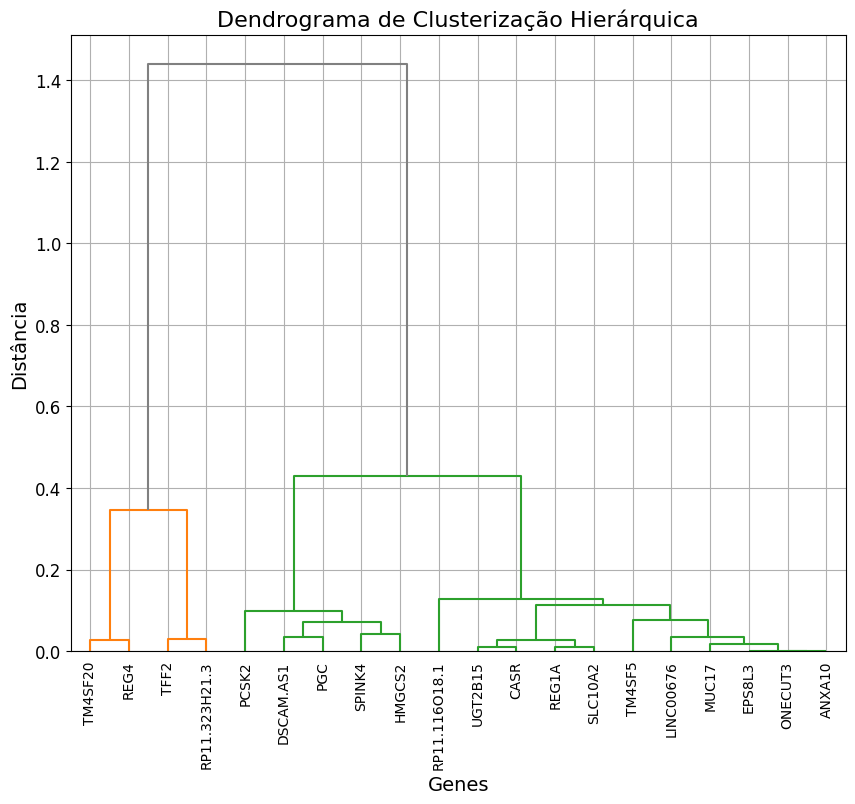

In [ ]:

print('A preparar dados para clustering: escalar, estimar distância, clusterizar.')

# Assume 'rdf' is a DataFrame with a 'log2FoldChange' column
res_ord = rdf.sort_values(by='log2FoldChange').log2FoldChange.to_frame(name='log2FoldChange').head(20)

# Scaling the selected data
scaled = sklearn.preprocessing.scale(res_ord)

# Performing hierarchical/agglomerative clustering
Z = scipy.cluster.hierarchy.linkage(scaled, metric='cityblock')

# Create a figure
matplotlib.pyplot.figure(figsize=(10, 8))

# Plot the dendrogram
dendro = scipy.cluster.hierarchy.dendrogram(
    Z,
    labels=list(res_ord.index),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.7 * max(Z[:, 2]),  # Set a color threshold for better visual separation
    above_threshold_color='gray'  # Color for clusters above the threshold
)

# Add title and labels
matplotlib.pyplot.title("Dendrograma de Clusterização Hierárquica", fontsize=16)
matplotlib.pyplot.xlabel("Genes", fontsize=14)
matplotlib.pyplot.ylabel("Distância", fontsize=14)

# Customize the font and layout
matplotlib.pyplot.xticks(fontsize=10)
matplotlib.pyplot.yticks(fontsize=12)
matplotlib.pyplot.grid(True)

# Save the dendrogram plot to a PDF file
matplotlib.pyplot.savefig('./output/dendrograma.pdf', bbox_inches='tight')

# Show the plot
print('A exibir dendrograma. Dendrograma gravado em ./output/')
matplotlib.pyplot.show()


Um dendrograma é uma representação gráfica comumente utilizada na interpretação de resultados de clustering, oferecendo insights valiosos sobre a estrutura hierárquica dos clusters. Cada nó no dendrograma representa um grupo de objetos, e a altura de cada nó indica a dissimilaridade entre os clusters unidos. A interpretação de um dendrograma envolve a análise das ramificações e dos padrões de agrupamento, identificando clusters bem definidos e a distância entre eles. Os clusters que se unem em níveis mais baixos do dendrograma são mais similares entre si, enquanto aqueles que se unem em níveis mais altos podem compartilhar características mais amplas. Ao observar a altura em que os clusters são agrupados, é possível identificar os diferentes níveis de similaridade e dissimilaridade entre os grupos. Além disso, a estrutura do dendrograma pode revelar informações sobre a heterogeneidade dos dados e a presença de subgrupos distintos. Em resumo, a interpretação de um dendrograma requer a análise cuidadosa de sua estrutura e ramificações, proporcionando uma compreensão detalhada da organização hierárquica dos clusters e das relações entre os objetos agrupados.

# Machine Learning

Para a previsão do fenótipo do subtipo de carcinoma do pulmão com base no perfil de expressão genética, foi explorado adicionalmente mais um modelo relativamente àqueles que foram testados em R:

* Random Forests

* Multi-Layer Perceptron (MLP)

* Support Vector Machine (SVM)

Nesta parte de Python, decidimos testar adicionalmente o modelo dos K-vizinhos.


Para realizar a aprendizagem máquina vamos usar o dataframe **seqdata_clean** e, em primeiro lugar logaritmizar os dados para, de seguida, calcular a variabilidade dos genes. 

In [61]:
seqdata_clean

,TCGA-55-7914-01A-11R-2170-07,TCGA-95-7043-01A-11R-1949-07,TCGA-73-4658-01A-01R-1755-07,TCGA-55-7726-01A-11R-2170-07,TCGA-44-6147-01A-11R-A278-07,TCGA-50-5932-01A-11R-1755-07,TCGA-44-2661-01A-01R-1107-07,TCGA-64-5775-01A-01R-1628-07,TCGA-73-4662-01A-01R-1206-07,TCGA-44-7671-01A-11R-2066-07,...,TCGA-05-4417-01A-22R-1858-07,TCGA-44-7662-01A-11R-2066-07,TCGA-69-7980-01A-11R-2187-07,TCGA-49-4506-01A-01R-1206-07,TCGA-78-7153-01A-11R-2039-07,TCGA-50-5055-01A-01R-1628-07,TCGA-38-4628-01A-01R-1206-07,TCGA-86-7713-01A-11R-2066-07,TCGA-44-2662-01B-02R-A277-07,TCGA-53-7626-01A-12R-2066-07
Genes,,,,,,,,,,,,,,,,,,,,,
TSPAN6,2936,1475,3659,1188,2178,4545,4558,3577,6839,3794,...,2292,3513,4915,1998,5479,2078,3942,8522,667,3249
TNMD,0,0,188,0,4,0,0,13,150,7,...,3,0,0,3,3,5,1,0,10,0
DPM1,1447,1275,981,1564,1430,1557,2089,1206,2512,1695,...,654,3093,2023,1969,1015,1004,3034,2548,554,1969
SCYL3,827,373,456,269,1139,1185,1025,263,2889,1007,...,460,1291,1156,983,549,368,1280,2384,716,1345
C1orf112,241,172,158,219,434,322,315,172,1865,295,...,165,1794,670,665,204,117,913,1790,619,427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288669,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
ENSG00000288670,446,100,115,107,252,341,126,275,1584,489,...,149,353,422,613,311,61,255,586,228,570
ENSG00000288671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Logaritmização

In [67]:
# Logaritmizar os valores dos genes
seqdata_log = numpy.log1p(seqdata_clean)  # Usando log1p para evitar erros com valores 0

print(seqdata_log)

                 TCGA-55-7914-01A-11R-2170-07  TCGA-95-7043-01A-11R-1949-07  \
Genes                                                                         
TSPAN6                               7.985144                      7.297091   
TNMD                                 0.000000                      0.000000   
DPM1                                 7.277939                      7.151485   
SCYL3                                6.719013                      5.924256   
C1orf112                             5.488938                      5.153292   
...                                       ...                           ...   
ENSG00000288669                      0.000000                      0.000000   
ENSG00000288670                      6.102559                      4.615121   
ENSG00000288671                      0.000000                      0.000000   
ENSG00000288674                      1.098612                      0.693147   
ENSG00000288675                      2.397895       

### Variabilidade

In [68]:
# Calcular a variabilidade dos genes
variabilidade_genes = seqdata_log.var(axis=1)

print(variabilidade_genes)

Genes
TSPAN6             0.431629
TNMD               1.908180
DPM1               0.341663
SCYL3              0.299508
C1orf112           0.446335
                     ...   
ENSG00000288669    0.098159
ENSG00000288670    0.398700
ENSG00000288671    0.000000
ENSG00000288674    0.489248
ENSG00000288675    0.612254
Length: 60660, dtype: float64


In [80]:
# Ordenar os genes por variabilidade em ordem decrescente
select_var = variabilidade_genes.sort_values(ascending=False).index.tolist()

# Selecionar as linhas da matriz 'logcounts' com base nos índices fornecidos em 'select_var'
highly_variable_lcpm = seqdata_log.loc[select_var]


In [81]:
highly_variable_lcpm

,TCGA-55-7914-01A-11R-2170-07,TCGA-95-7043-01A-11R-1949-07,TCGA-73-4658-01A-01R-1755-07,TCGA-55-7726-01A-11R-2170-07,TCGA-44-6147-01A-11R-A278-07,TCGA-50-5932-01A-11R-1755-07,TCGA-44-2661-01A-01R-1107-07,TCGA-64-5775-01A-01R-1628-07,TCGA-73-4662-01A-01R-1206-07,TCGA-44-7671-01A-11R-2066-07,...,TCGA-05-4417-01A-22R-1858-07,TCGA-44-7662-01A-11R-2066-07,TCGA-69-7980-01A-11R-2187-07,TCGA-49-4506-01A-01R-1206-07,TCGA-78-7153-01A-11R-2039-07,TCGA-50-5055-01A-01R-1628-07,TCGA-38-4628-01A-01R-1206-07,TCGA-86-7713-01A-11R-2066-07,TCGA-44-2662-01B-02R-A277-07,TCGA-53-7626-01A-12R-2066-07
Genes,,,,,,,,,,,,,,,,,,,,,
RPS4Y1,0.000000,0.693147,0.000000,0.000000,2.484907,9.622847,1.098612,9.604812,0.000000,9.728539,...,1.609438,8.117014,0.000000,3.258097,2.772589,0.000000,1.609438,9.673068,6.298949,0.000000
FGB,0.693147,1.791759,1.386294,0.000000,3.218876,4.532599,0.693147,2.302585,2.484907,9.696586,...,9.222368,0.693147,7.792349,9.780416,12.171031,0.000000,5.749393,9.322150,2.397895,2.302585
XIST,6.664409,8.287025,5.631212,7.880426,8.784162,1.098612,8.038189,1.098612,8.593413,1.386294,...,6.796824,0.000000,9.232004,5.298317,6.834109,6.214608,5.337538,0.693147,4.025352,8.437934
DDX3Y,0.000000,0.000000,0.693147,0.000000,2.639057,7.860956,0.693147,7.816820,0.000000,7.708411,...,0.000000,7.448916,0.000000,1.386294,0.693147,0.000000,0.693147,8.841448,7.480992,0.693147
KDM5D,0.000000,0.693147,0.000000,0.000000,2.079442,5.613128,0.693147,6.654153,0.000000,7.781139,...,0.000000,7.288244,0.693147,0.693147,0.693147,0.000000,0.000000,8.295299,6.960348,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNORD30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000285283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000285292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
# Transpor o DataFrame highly_variable_lcpm e armazenar o resultado em expr_data
expr_data = highly_variable_lcpm.transpose()

In [93]:
# Remover a coluna "gender" do DataFrame
meta_expr = meta_clean.drop(columns=['gender'])
meta_expr

,expr
barcode,
TCGA-55-7914-01A-11R-2170-07,TRU
TCGA-95-7043-01A-11R-1949-07,prox.-prolif.
TCGA-73-4658-01A-01R-1755-07,prox.-inflam
TCGA-55-7726-01A-11R-2170-07,prox.-inflam
TCGA-44-6147-01A-11R-A278-07,TRU
...,...
TCGA-50-5055-01A-01R-1628-07,TRU
TCGA-38-4628-01A-01R-1206-07,prox.-inflam
TCGA-86-7713-01A-11R-2066-07,prox.-prolif.


In [94]:
# Adicionar a coluna 'phenotype' ao DataFrame de expressão genética com base no índice
expr_data['phenotype'] = meta_expr['expr']

### Criação dos dados de treino e treino dos modelos

In [172]:
from sklearn.model_selection import train_test_split

# Supondo que expr_profiles seja o DataFrame original com a coluna 'phenotype'

# Separar os dados em características (X) e alvo (y)
X = expr_data.drop(columns=['phenotype'])
y = expr_data['phenotype']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modelo KNN

In [173]:
# Inicializar o classificador KNN
knn = KNeighborsClassifier()

# Treinar o modelo KNN
knn.fit(X_train.iloc[:, :100], y_train)

# Avaliar o modelo
accuracy = knn.score(X_test.iloc[:, :100], y_test)
print("Acurácia do modelo KNN:", accuracy)

Acurácia do modelo KNN: 0.64


In [174]:
# Inicializar o classificador KNN
knn = KNeighborsClassifier()

# Treinar o modelo KNN
knn.fit(X_train.iloc[:, :500], y_train)

# Avaliar o modelo
accuracy = knn.score(X_test.iloc[:, :500], y_test)
print("Acurácia do modelo KNN:", accuracy)

Acurácia do modelo KNN: 0.74


In [175]:
# Inicializar o classificador KNN
knn = KNeighborsClassifier()

# Treinar o modelo KNN
knn.fit(X_train.iloc[:, :1000], y_train)

# Avaliar o modelo
accuracy = knn.score(X_test.iloc[:, :1000], y_test)
print("Acurácia do modelo KNN:", accuracy)

Acurácia do modelo KNN: 0.76


In [176]:
# Inicializar o classificador KNN
knn = KNeighborsClassifier()

# Treinar o modelo KNN
knn.fit(X_train.iloc[:, :10000], y_train)

# Avaliar o modelo
accuracy = knn.score(X_test.iloc[:, :10000], y_test)
print("Acurácia do modelo KNN:", accuracy)

Acurácia do modelo KNN: 0.72


In [178]:
# Inicializar o classificador KNN
knn = KNeighborsClassifier()

# Treinar o modelo KNN
knn.fit(X_train.iloc[:, :60660], y_train)

# Avaliar o modelo
accuracy = knn.score(X_test.iloc[:, :60660], y_test)
print("Acurácia do modelo KNN:", accuracy)

Acurácia do modelo KNN: 0.62


### Algoritmo Naive-Bayes

In [182]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Selecionar as primeiras 100 características
X_train_100 = X_train.iloc[:, :100]
X_test_100 = X_test.iloc[:, :100]

# Criar e treinar o modelo Naive Bayes Gaussiano
naive_bayes_model = GaussianNB()

# Treinar o modelo
naive_bayes_model.fit(X_train_100, y_train)

# Fazer previsões no conjunto de teste
y_pred = naive_bayes_model.predict(X_test_100)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo Naive Bayes com as primeiras 100 características:", accuracy)


Acurácia do modelo Naive Bayes com as primeiras 100 características: 0.68


In [183]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Selecionar as primeiras 100 características
X_train_100 = X_train.iloc[:, :500]
X_test_100 = X_test.iloc[:, :500]

# Criar e treinar o modelo Naive Bayes Gaussiano
naive_bayes_model = GaussianNB()

# Treinar o modelo
naive_bayes_model.fit(X_train_100, y_train)

# Fazer previsões no conjunto de teste
y_pred = naive_bayes_model.predict(X_test_100)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo Naive Bayes com as primeiras 100 características:", accuracy)

Acurácia do modelo Naive Bayes com as primeiras 100 características: 0.82


In [184]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Selecionar as primeiras 100 características
X_train_100 = X_train.iloc[:, :1000]
X_test_100 = X_test.iloc[:, :1000]

# Criar e treinar o modelo Naive Bayes Gaussiano
naive_bayes_model = GaussianNB()

# Treinar o modelo
naive_bayes_model.fit(X_train_100, y_train)

# Fazer previsões no conjunto de teste
y_pred = naive_bayes_model.predict(X_test_100)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo Naive Bayes com as primeiras 100 características:", accuracy)

Acurácia do modelo Naive Bayes com as primeiras 100 características: 0.86


In [185]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Selecionar as primeiras 100 características
X_train_100 = X_train.iloc[:, :5000]
X_test_100 = X_test.iloc[:, :5000]

# Criar e treinar o modelo Naive Bayes Gaussiano
naive_bayes_model = GaussianNB()

# Treinar o modelo
naive_bayes_model.fit(X_train_100, y_train)

# Fazer previsões no conjunto de teste
y_pred = naive_bayes_model.predict(X_test_100)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo Naive Bayes com as primeiras 100 características:", accuracy)

Acurácia do modelo Naive Bayes com as primeiras 100 características: 0.88


In [187]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Selecionar as primeiras 100 características
X_train_100 = X_train.iloc[:, :60660]
X_test_100 = X_test.iloc[:, :60660]

# Criar e treinar o modelo Naive Bayes Gaussiano
naive_bayes_model = GaussianNB()

# Treinar o modelo
naive_bayes_model.fit(X_train_100, y_train)

# Fazer previsões no conjunto de teste
y_pred = naive_bayes_model.predict(X_test_100)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo Naive Bayes com as primeiras 100 características:", accuracy)

Acurácia do modelo Naive Bayes com as primeiras 100 características: 0.52
